# Breast Cancer Detection with KNN - Classification Challange

## Description

Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases, and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.

The key challenges against it’s detection is how to classify tumors into malignant (cancerous) or benign(non cancerous). We ask you to complete the analysis of classifying these tumors using machine learning (with SVMs) and the Breast Cancer Wisconsin (Diagnostic) Dataset.

## Acknowledgements

This dataset has been referred from Kaggle.

## Objective

- Understand the Dataset & cleanup (if required).
- Build classification models to predict whether the cancer type is Malignant or Benign.
- Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression

## Load Dataset

In [2]:
dataset_path = './breast-cancer.csv'

df = pd.read_csv(dataset_path)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

### Checking if the dataset is balance or unbalance

B -> benign     (non cancerous)
M -> malignant  (cancerous)

In [4]:
df.loc[:, ['id' ,'diagnosis']].groupby('diagnosis').count().reset_index()

,diagnosis,id
0,B,357
1,M,212


It can be seen that, this dataset is unbalanced because, the amount of malignant tumors is only 37% of the total but the benign tumors amount to 62%

This means that for the next steps, the solution for the correct classifications of the tumors must consider the dataset as unbalance, otherwise it may get bad results in the classifications of the tumors.

## Features Selection

In [5]:
# x = training_features
# y = label

features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'
       ]

label = 'diagnosis'

#x_train = df.loc[:, features]
#y_train = df.loc[:, label]

## Training

### Spliting the Data into -> Training, test, validate

"Numpy solution"
Will shuffle the whole dataset first `df.sample(frac=1, random_state=42)` and then split the data set into the following parts:
- 60% -> train set;
- 20% -> validation set;
- 20% -> test set;

The spliting of the data into 3 different parts is needed to make sure that the algorithm is correctly asnwearing/classifing the tumors, and not simply memorizing the answears.

For that it is separated the dataset in 2 or 3, training set, validation set, test set.

Training Set: The model learns patterns and relationships from this data. The model sees and learns directly from this data to adjust its internal parameters (weights and biases).

Validation Set: Used to fine-tune the model's structure or hyperparameters (e.g., learning rate, number of layers) and compare candidate models. The model's performance on this data is evaluated frequently during development, but the model does not learn directly from it.

Test Set: Used to provide a final, unbiased evaluation of the chosen, fully-tuned model's ability to generalize to truly unseen data. This data is only used once, at the very end, and is kept completely isolated throughout the entire development process.

Risk if used incorrectly

- Training Set: Underfitting (if too small or not diverse) or Overfitting (if training is run too long).

- Validation Set: Overfitting to the validation set (if used too many times to guide design choices).

- Test Set: An overly optimistic or unreliable estimate of real-world performance.

In [6]:
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

x_train = train.loc[:, features]
y_train = train.loc[:, label]

x_validate = validate.loc[:, features]
y_validate = validate.loc[:, label]

x_test = test.loc[:, features]
y_test = test.loc[:, label]

d:\Anaconda\envs\git\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Checking the size of each set

In [7]:
train.shape

(341, 32)

In [8]:
validate.shape

(114, 32)

In [9]:
test.shape

(114, 32)

## KNN Training

### Finding best k for imbalanced dataset

#### Sensitivity-Specificity Metrics

Sensitivity refers to the true positive rate and summarizes how well the positive class was predicted.

$$
Sensitivity = \frac{TruePositive}{TruePositive + FalseNegative}
$$

Specificity is the complement to sensitivity, or the true negative rate, and summarises how well the negative class was predicted.

$$
Specificity = \frac{TrueNegative}{FalsePositive + TrueNegative}
$$

For imbalanced classification, the sensitivity might be more interesting than the specificity.

Sensitivity and Specificity can be combined into a single score that balances both concerns, called the geometric mean or G-Mean.

$$
G_Mean = sqrt(Sensitivity * Specificitu)
$$

Because the benign tumor is the Positive, and the malignant is the Negative, the logic is reversed, as it's understood that is more important to correct classify the the malignant tumors

Training the algorithm with KNN and validating it.
Using the Elbow Method to verify the best K means/value

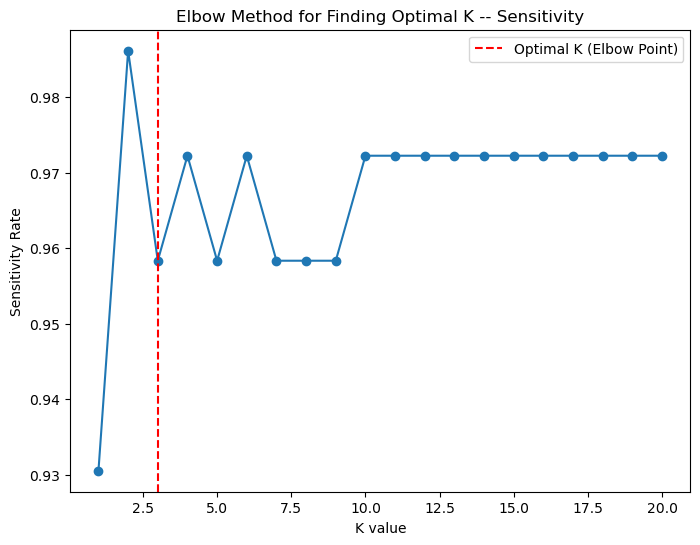

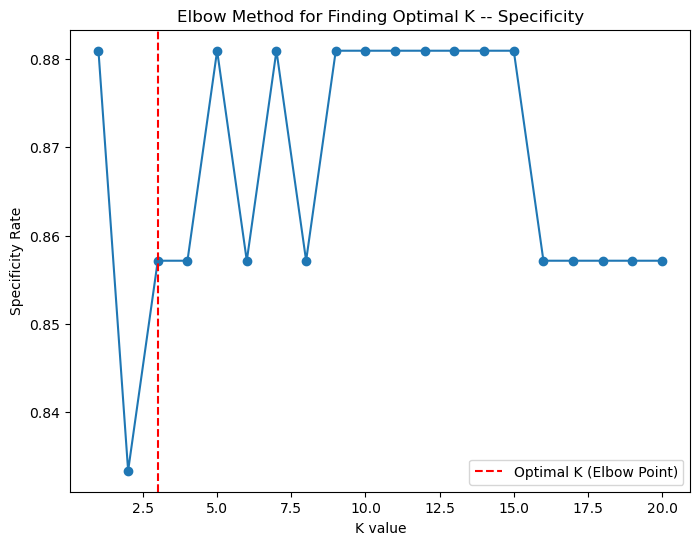

In [10]:
# defining the training parameters

k_values = range(1, 21)
error_rates = []
sensitivity_rates = []
specificity_rates = []

for k in k_values:
  knn_classifier = KNeighborsClassifier( n_neighbors = k )

  # Training the algorithm with trhe training set
  knn_classifier.fit( x_train, y_train )

  # Now using the validation set to verify the results of the training
  y_pred = knn_classifier.predict(x_validate)

  cm = mt.confusion_matrix(y_validate,y_pred)

  TP = cm[0][0] # true benign tumor
  FN = cm[0][1] # false benign tumor
  TN = cm[1][1] # true malignant tumor
  FP = cm[1][0] # false malignant tumor

  SENSITIVITY = TP / (TP + FN)
  SPECIFICITY = TN / (FP + TN)
  sensitivity_rates.append(SENSITIVITY)
  specificity_rates.append(SPECIFICITY)

plt.figure(figsize=(8,6))
plt.plot(k_values, sensitivity_rates, marker='o')
plt.xlabel('K value')
plt.ylabel('Sensitivity Rate')
plt.title('Elbow Method for Finding Optimal K -- Sensitivity')
plt.axvline(x=3, linestyle='--', color='red', label='Optimal K (Elbow Point)')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(k_values, specificity_rates, marker='o')
plt.xlabel('K value')
plt.ylabel('Specificity Rate')
plt.title('Elbow Method for Finding Optimal K -- Specificity')
plt.axvline(x=3, linestyle='--', color='red', label='Optimal K (Elbow Point)')
plt.legend()
plt.show()

1 and 2 are being ignored because it is understood as cases of overffiting

With the graph genereted by the Elbow Method, it can be interpreted that the best K value for Sensitivity is [4, 6, 10...] while for Specificity is [5, 7, 9-15]

That being said, it can be seen that in this case the K=10 is the point where both Specificity and Sensitivity converge to their highst.

### Definition of the paramets for training, based on the elbow method

It is being used k as 10, for being the point where both Specificity and Sensitivity are at their highest.

Note: For being a disease it is being deemed to be more important to correct classify the malignant tumors than the benign.  So if need to change the K value to lower as to get a better Specificity, it may be better to do so.

In [11]:
# definindo parametros do treinamento
k = 10
knn_classifier = KNeighborsClassifier( n_neighbors = k )

# treinamento do algoritmo
knn_classifier.fit( x_train, y_train )

y_pred = knn_classifier.predict(x_validate)

cm = mt.confusion_matrix(y_validate,y_pred)

TP = cm[0][0] # true benign tumor
FN = cm[0][1] # false benign tumor
TN = cm[1][1] # true malignt tumor
FP = cm[1][0] # false malignt tumor

SENSITIVITY = TP / (TP + FN)

SPECIFICITY = TN / (FP + TN)

print(f'SENSITIVITY = {SENSITIVITY}') # Is checkign the TRUE BENIGN TUMOR
print(f'SPECIFICITY = {SPECIFICITY}') # Is checkign the TRUE MALIGNT TUMOR

SENSITIVITY = 0.9722222222222222
SPECIFICITY = 0.8809523809523809


# Now Testing the algorithm with the Test Set

## Prediction of the KNN

In [12]:
y_pred_knn_final = knn_classifier.predict(x_test)
y_pred_proba_knn = knn_classifier.predict_proba(x_test)[:,1]
percentiles_knn = np.percentile(y_pred_proba_knn, [5, 25, 50, 75, 95])
print(percentiles_knn)

[0.  0.  0.  0.9 1. ]


## Using Logistic Regression, to gain a basic comparsion

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

d:\Anaconda\envs\git\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Prediction of the Logistic Regression

In [14]:
y_pred_logReg = model.predict_proba(x_test)[:, 1] # returns probabability of the positive outcome

percentiles_logReg = np.percentile(y_pred_logReg, [5,25,50,75,95])
print(percentiles_logReg)

[1.20120755e-04 1.79563026e-03 3.82557286e-02 9.96248870e-01
 1.00000000e+00]


In [15]:
#df_result = train.copy()
df_result_knn = test.copy()
df_result_knn['classificacao'] = y_pred
#
df_result_logReg = test.copy()
df_result_logReg['classificacao'] = y_pred_logReg

### Confusion Matrix (KNN)

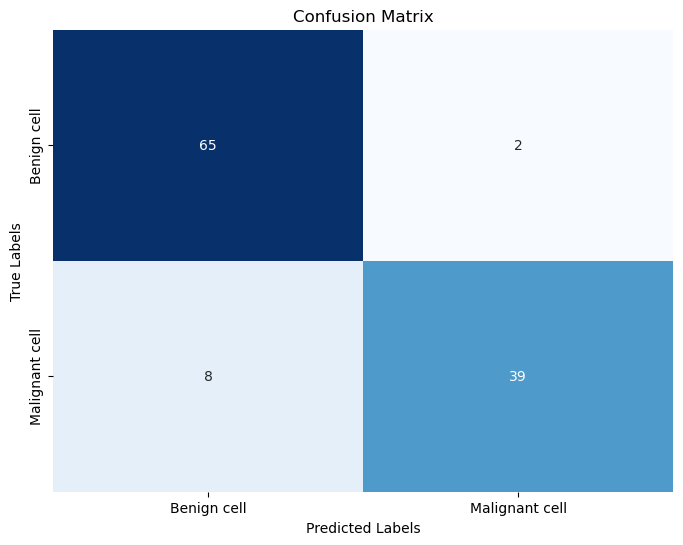

In [16]:
cm_knn = mt.confusion_matrix(y_test, y_pred_knn_final)

disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm_knn)

#disp.plot(cmap=plt.cm.Blues)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5,1.5], ['Benign cell', 'Malignant cell'])
plt.yticks([0.5,1.5], ['Benign cell', 'Malignant cell'], va='center')
plt.show()

Note: when the K value was 5, the Confusion Matrix was a bit different.
[
  [64, 3],
  [7, 40]
]
It is a small change but, it is one person less being wrong classified with a benign tumor.
Now is the opposite one less person being wrong classified with a malignant tumor.

## Métricas Finais (KNN)

In [17]:
recall_knn = mt.recall_score(y_test, y_pred_knn_final, pos_label='B')
specificity_knn = mt.recall_score(y_test, y_pred_knn_final, pos_label='M')
precision_knn = mt.precision_score(y_test, y_pred_knn_final, pos_label='B')
f1_knn = mt.f1_score(y_test, y_pred_knn_final, pos_label='B')
accuracy_knn = mt.accuracy_score(y_test,y_pred_knn_final)


print(f"KNN Final Recall (Sensitivity): {recall_knn:.4f}")
print(f"KNN Final Specificity: {specificity_knn:.4f}")
print(f"KNN Final Precision: {precision_knn:.4f}")
print(f"KNN Final F1 Score: {f1_knn:.4f}")
print(f'KNN Final Accuracy = {accuracy_knn:.4f}')

KNN Final Recall (Sensitivity): 0.9701
KNN Final Specificity: 0.8298
KNN Final Precision: 0.8904
KNN Final F1 Score: 0.9286
KNN Final Accuracy = 0.9123


Final Recall (Sensitivity):
  - This metric is responsible in telling if the correct identification of - Benigent cells is good or not
  - In other words this metrics tell you the percentage of people who the model corretly identified as okay

Specificity:
  - This metrics measures the correct identification of the patients with cangeriginous cells

Precision:
  - From all the times the model predict someone to be fine how often were they actually fine

Accuracy:
  - The total percent of the time the models gets a correct prediction
  - This metric is not allways trustful, for example imagine the data had 100 people, 10 have cancer.
  - If I miss all this 10 people and said they were fine, I'd still score 90%
  - More used to compare classifications models/algorithms

F1 Score:
  - The harmonic mean of precision and recall

### ROC/AUC Comparsion

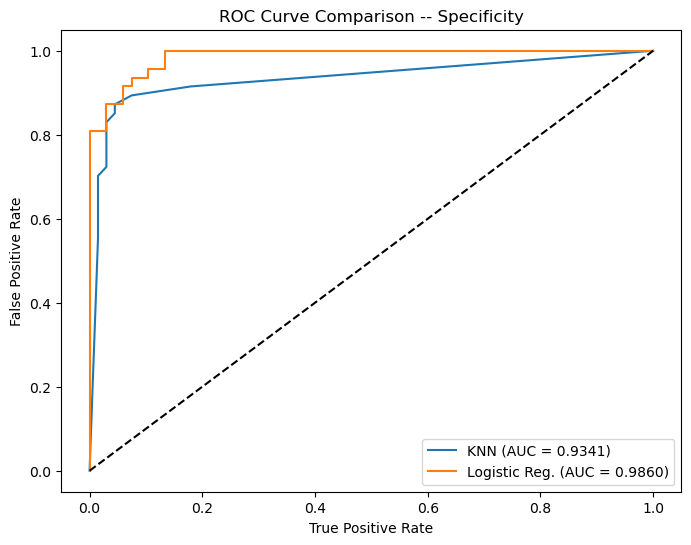

In [19]:
# KNN
  # get ROC curve values
fpr_knn, tpr_knn, _ = mt.roc_curve(y_test, y_pred_proba_knn, pos_label='M')
  # get areas under the curves
auc_knn = mt.roc_auc_score(y_test, y_pred_proba_knn)

# Logistic Regression
  # get ROC curve values
fpr_logreg, tpr_logreg, _ = mt.roc_curve(y_test, y_pred_logReg, pos_label='M')
  # get areas under the curves
auc_logreg = mt.roc_auc_score(y_test, y_pred_logReg)

plt.figure(figsize=(8,6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.4f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Reg. (AUC = {auc_logreg:.4f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve Comparison -- Specificity')
plt.legend()
plt.show()

Here is necessary to remember:
Negatives == malignant while Positives == benign

### Precision-Recall Curve (KNN)

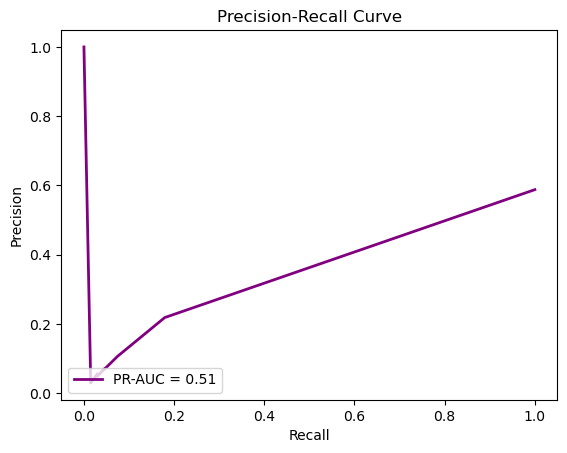

In [20]:
precision, recall, threshold_pr = mt.precision_recall_curve(y_test, y_pred_proba_knn, pos_label='B')

pr_auc = mt.average_precision_score(y_test, y_pred_proba_knn, pos_label='B')

# plot precision recall curve
plt.plot(recall, precision, color='purple', lw=2, label=f'PR-AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

## Prevelance
"How prevelant is the positive class (B)"

# KNN - "Hits"

In [21]:
df_result_knn.loc[:, ['id', 'diagnosis','classificacao']].sample(10)

,id,diagnosis,classificacao
484,912600,B,B
64,85922302,M,M
106,863031,B,M
308,893526,B,B
99,862548,M,M
130,866714,B,B
80,861103,B,B
160,8711561,B,M
295,891923,B,M
300,892438,M,B


In [22]:
df_result_knn['acertos'] = (df_result_knn.loc[:, ['id', 'diagnosis', 'classificacao']]
                        .apply(
                          lambda x: 1 if x['diagnosis'] == x['classificacao'] else 0, axis=1
                          )
                      )

In [23]:
acertos = df_result_knn['acertos'].sum()

print(f'Total de acertos = {acertos}/{df_result_knn.shape[0]}')

Total de acertos = 62/114


---

In [24]:
df_result_knn.loc[:, ['id', 'diagnosis', 'classificacao','acertos']].sample(10)

,id,diagnosis,classificacao,acertos
303,892657,B,M,0
309,893548,B,B,1
40,855167,M,B,0
508,915452,B,B,1
522,91789,B,M,0
205,879523,M,M,1
14,84667401,M,B,0
189,874839,B,M,0
187,874373,B,B,1
80,861103,B,B,1
